In [267]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#Randomforest
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss
from catboost import CatBoostClassifier


import math
from copy import deepcopy
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt


import os

In [43]:
#change directory
os.chdir("D:/HoTes/CSC7305c_ML_Hot_2383_Batch49/Tennis dataset_stacking_adab_xgb")

In [44]:
#read datasets
tennis_data= pd.read_csv("Batch49_CSE7305c_CuTE_train-1544001028037.csv")

In [45]:
#shape
tennis_data.shape

(8001, 27)

In [46]:
#datatypes
tennis_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8001 entries, 0 to 8000
Data columns (total 27 columns):
rally                                 8001 non-null int64
serve                                 8001 non-null int64
hitpoint                              8001 non-null object
speed                                 8001 non-null float64
net.clearance                         8001 non-null float64
distance.from.sideline                8001 non-null float64
depth                                 8001 non-null float64
outside.sideline                      8001 non-null bool
outside.baseline                      8001 non-null bool
player.distance.travelled             8001 non-null float64
player.impact.depth                   8001 non-null float64
player.impact.distance.from.center    8001 non-null float64
player.depth                          8001 non-null float64
player.distance.from.center           8001 non-null float64
previous.speed                        8001 non-null float64
prev

In [47]:
# Columns in Data With Categorical Values- Must LabelEncode them
categorical_cols = ['hitpoint', 'outside.sideline', 'outside.baseline', 'same.side', 
                    'previous.hitpoint', 'server.is.impact.player', 'outcome']

# Columns in the Data That Should Be Scaled
scaled_data = ['serve', 'rally', 'speed', 'net.clearance', 'distance.from.sideline', 'depth', 'player.distance.travelled', 
               'player.impact.depth', 'player.impact.distance.from.center', 'player.depth', 
               'player.distance.from.center', 'previous.speed', 'previous.net.clearance', 
               'previous.distance.from.sideline', 'previous.depth', 'opponent.depth', 
               'opponent.distance.from.center', 'previous.time.to.net']

In [48]:
tennis_data = tennis_data.drop(['gender', 'ID'], axis=1)

In [49]:
tennis_data[categorical_cols]= tennis_data[categorical_cols].astype('category')

In [50]:
tennis_data.isnull().sum()

rally                                 0
serve                                 0
hitpoint                              0
speed                                 0
net.clearance                         0
distance.from.sideline                0
depth                                 0
outside.sideline                      0
outside.baseline                      0
player.distance.travelled             0
player.impact.depth                   0
player.impact.distance.from.center    0
player.depth                          0
player.distance.from.center           0
previous.speed                        0
previous.net.clearance                0
previous.distance.from.sideline       0
previous.depth                        0
opponent.depth                        0
opponent.distance.from.center         0
same.side                             0
previous.hitpoint                     0
previous.time.to.net                  0
server.is.impact.player               0
outcome                               0


## Feature Engineering

In [51]:
####################### Feature Engineering #################
def feature_engineer(data):
    
    # Speed difference between previous and last shot
    data['speed.difference'] = data['speed'] - data['previous.speed']
    
    # Net clearance difference between previous and last shot
    data['net.clearance.difference'] = data['net.clearance'] - data['previous.net.clearance']
    
    # The actual distance the player was from the sideline
    data['true.distance.from.sideline'] = [dist if not boolean else (dist * -1) 
                                           for dist, boolean in 
                                           zip(data['distance.from.sideline'], 
                                               data['outside.sideline'])]

    # The actual distance the player was from the baseline
    data['true.distance.from.baseline'] = [dist if not boolean else (dist * -1) 
                                           for dist, boolean in 
                                           zip(data['depth'], 
                                               data['outside.baseline'])]

    # Opponent distance to net + player distance to net
    data['player.distance.from.other.length'] = data['player.depth'] + data['opponent.depth']

    # Opponent distance from center + player distance to center
    data['player.distance.from.other.width'] = [math.fabs(p_center - o_center)
                                                     if boolean else p_center + o_center
                                                     for p_center, o_center, boolean in 
                                                     zip(data['player.distance.from.center'], 
                                                         data['opponent.distance.from.center'], 
                                                         data['same.side'])]

    # Straight line distance between players
    data['bw.player.distance.penultimate'] = [math.hypot(length, width)
                                                 for length, width in 
                                                 zip(data['player.distance.from.other.length'], 
                                                     data['player.distance.from.other.width'])]

    # Distance penultimate shot was made from net- previous to net (s) * penultimate shot (m/s)
    data['player.from.net.penultimate'] = data['previous.speed'] * data['previous.time.to.net']
    
    return data

# Perform Feature Engineering
tennis_data_fe = feature_engineer(tennis_data)

In [52]:
tennis_data_fe.head()

,rally,serve,hitpoint,speed,net.clearance,distance.from.sideline,depth,outside.sideline,outside.baseline,player.distance.travelled,...,server.is.impact.player,outcome,speed.difference,net.clearance.difference,true.distance.from.sideline,true.distance.from.baseline,player.distance.from.other.length,player.distance.from.other.width,bw.player.distance.penultimate,player.from.net.penultimate
0,4,1,B,35.515042,-0.021725,3.474766,6.797621,False,False,1.467570,...,False,UE,3.201450,-1.372257,3.474766,6.797621,26.2332,1.8394,26.297608,14.389823
1,4,2,B,33.382640,1.114202,2.540801,2.608708,False,True,2.311931,...,False,FE,-0.678148,0.353704,2.540801,-2.608708,24.9902,7.4286,26.070945,14.729042
2,23,1,B,22.316690,-0.254046,3.533166,9.435749,False,False,3.903728,...,True,FE,-17.489938,-0.631778,3.533166,9.435749,27.5616,3.7472,27.815163,15.824638
3,9,1,F,36.837309,0.766694,0.586885,3.342180,True,False,0.583745,...,True,UE,11.818491,-0.472339,-0.586885,3.342180,27.4088,0.1418,27.409167,16.812251
4,4,1,B,35.544208,0.116162,0.918725,5.499119,False,False,2.333456,...,False,W,-1.246771,-0.049569,0.918725,5.499119,25.4968,1.4232,25.536490,12.524057


In [53]:
tennis_data_fe.shape

(8001, 33)

In [54]:
# Columns to be dropped
dropcols = ['same.side', 'server.is.impact.player', 
                  'outside.baseline', 'previous.hitpoint', 'hitpoint', 'rally', 'serve', 
                  'outside.sideline', 'player.distance.from.center', 'depth', 
                  'player.distance.from.other.length', 'bw.player.distance.penultimate',
                  'player.distance.from.other.width', 'previous.time.to.net',
                  'player.impact.distance.from.center', 'opponent.distance.from.center', 
                  'player.from.net.penultimate','net.clearance.difference']

tennis_data_fe = tennis_data_fe.drop(dropcols, axis=1) 

In [55]:
tennis_data_fe.shape

(8001, 15)

In [56]:
target = tennis_data_fe['outcome']

In [57]:
tennis_data_fe= tennis_data_fe.drop('outcome', axis=1)

In [58]:
tennis_data_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8001 entries, 0 to 8000
Data columns (total 14 columns):
speed                              8001 non-null float64
net.clearance                      8001 non-null float64
distance.from.sideline             8001 non-null float64
player.distance.travelled          8001 non-null float64
player.impact.depth                8001 non-null float64
player.depth                       8001 non-null float64
previous.speed                     8001 non-null float64
previous.net.clearance             8001 non-null float64
previous.distance.from.sideline    8001 non-null float64
previous.depth                     8001 non-null float64
opponent.depth                     8001 non-null float64
speed.difference                   8001 non-null float64
true.distance.from.sideline        8001 non-null float64
true.distance.from.baseline        8001 non-null float64
dtypes: float64(14)
memory usage: 875.2 KB


In [24]:
tennis_data_fe= pd.get_dummies(tennis_data_fe, drop_first=True)

In [25]:
tennis_data_fe.shape

(8001, 16)

In [26]:
tennis_data_fe.head()

,speed,net.clearance,distance.from.sideline,player.distance.travelled,player.impact.depth,player.depth,previous.speed,previous.net.clearance,previous.distance.from.sideline,previous.depth,opponent.depth,speed.difference,true.distance.from.sideline,true.distance.from.baseline,outcome_UE,outcome_W
0,35.515042,-0.021725,3.474766,1.467570,14.1758,13.6704,32.313592,1.350533,2.449182,0.705435,12.5628,3.201450,3.474766,6.797621,1,0
1,33.382640,1.114202,2.540801,2.311931,12.7396,12.6358,34.060788,0.760499,0.583291,3.856600,12.3544,-0.678148,2.540801,-2.608708,0,0
2,22.316690,-0.254046,3.533166,3.903728,15.3782,13.6996,39.806628,0.377732,1.115250,2.908892,13.8620,-17.489938,3.533166,9.435749,0,0
3,36.837309,0.766694,0.586885,0.583745,13.7308,13.1492,25.018818,1.239033,3.256695,0.557554,14.2596,11.818491,-0.586885,3.342180,1,0
4,35.544208,0.116162,0.918725,2.333456,15.1992,14.1310,36.790979,0.165731,1.431146,3.945317,11.3658,-1.246771,0.918725,5.499119,0,1


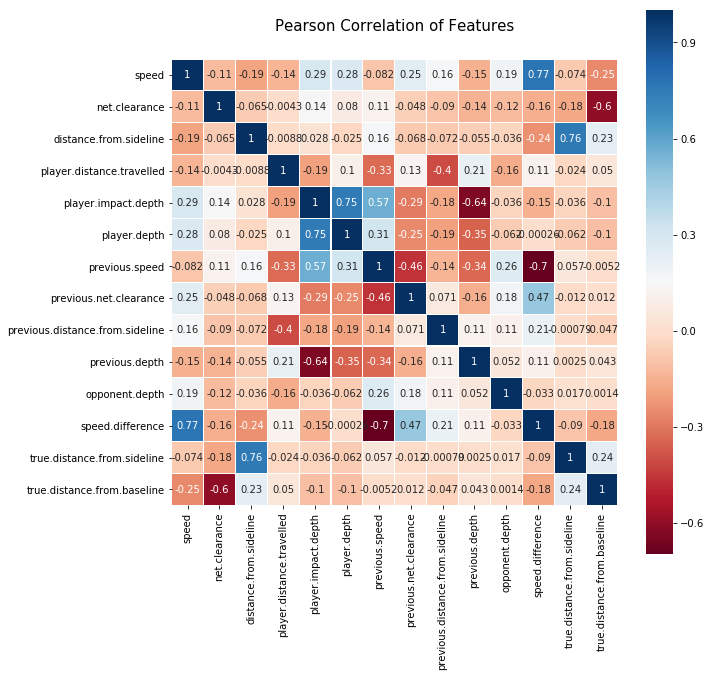

In [210]:
colormap = plt.cm.RdBu
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(tennis_data_fe.corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

## splitting

In [60]:
X_train, X_test, y_train, y_test = train_test_split(tennis_data_fe, target, test_size = 0.25, random_state = 786)

In [ ]:
#standardization

In [162]:
#train data standardization
from sklearn.preprocessing import StandardScaler
standardizer = StandardScaler()
standardizer.fit(X_train)
X_train = pd.DataFrame(standardizer.transform(X_train), columns=tennis_data_fe.columns)

In [164]:
#Test data standardization
standardizer = StandardScaler()
standardizer.fit(X_test)
X_test = pd.DataFrame(standardizer.transform(X_test), columns=tennis_data_fe.columns)

In [165]:
X_test.head()

,speed,net.clearance,distance.from.sideline,player.distance.travelled,player.impact.depth,player.depth,previous.speed,previous.net.clearance,previous.distance.from.sideline,previous.depth,opponent.depth,speed.difference,true.distance.from.sideline,true.distance.from.baseline
0,1.251841,0.172085,0.317546,0.172419,0.639689,0.552107,0.482919,-0.381947,-0.446773,-0.451524,0.181863,0.600468,0.439649,-1.122823
1,0.385337,-0.741854,0.315626,0.176469,0.456398,-0.057737,1.079780,-0.886178,-0.412138,-0.318133,0.486530,-0.405127,0.438103,0.725961
2,1.166139,-0.374440,-0.855796,-1.054190,0.376936,0.503636,-0.736615,1.155253,1.393809,-0.676829,0.635215,1.311106,-0.505484,0.286552
3,0.730793,-0.194214,0.448117,-0.952160,-0.251170,-0.463607,0.453810,-0.717097,0.853026,0.693034,-0.005939,0.241626,0.544824,-0.419230
4,0.781429,2.228198,-0.979172,1.041107,1.220581,1.336942,1.149344,-0.580086,-1.062001,-1.221139,-0.127378,-0.162397,-0.604864,-2.882417


## Model Building

In [172]:
#model
model_xgb= XGBClassifier(n_estimators=1000, random_state= 786, learning_rate= 0.1, 
                               subsample= 0.85, colsample_bytree= 0.8, 
                               eval_metric= 'mlogloss', max_depth= 6, 
                               min_child_weight= 1, gamma= 5)
#fit model
model_xgb.fit(X_train, y_train)

#predict
predicted_xgb = model_xgb.predict(X_train)
preds_val_xgb=model_xgb.predict(X_test)

#Accuracy
print ('Accuracy:', accuracy_score(y_train, predicted_xgb))
print ('Accuracy:', accuracy_score(y_test, preds_val_xgb))

Accuracy: 0.9165
Accuracy: 0.8655672163918041


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


## Adaboost

In [92]:
Adaboost_model = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=6,max_features=12, max_leaf_nodes=6,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.1, presort=False, random_state=123456,
            splitter='best'),
    n_estimators=1000,
    learning_rate=0.05)


Adaboost_model.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=12, max_leaf_nodes=6, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.1,
            presort=False, random_state=123456, splitter='best'),
          learning_rate=0.05, n_estimators=1000, random_state=None)

In [93]:
from sklearn.metrics import confusion_matrix
y_pred=Adaboost_model.predict(X_train)
y_pred1=Adaboost_model.predict(X_test)

print("Train Confusion matrix",confusion_matrix(y_train,y_pred))
print("Test Confusion matrix",confusion_matrix(y_test,y_pred1))

print("Train Accuracy Score",accuracy_score(y_train,y_pred))
print("Test Accuracy Score",accuracy_score(y_test,y_pred1))

Train Confusion matrix [[1046  278   34]
 [ 230 2322   70]
 [  15   37 1968]]
Test Confusion matrix [[336 108  16]
 [107 743  29]
 [ 15  31 616]]
Train Accuracy Score 0.8893333333333333
Test Accuracy Score 0.8470764617691154


## Grid search cv

In [97]:
#from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators':[100,150,200,500,1000], 'learning_rate' : [0.01,0.05,0.1,0.5,0.9]}
clf = GridSearchCV(AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=6)), param_grid, n_jobs=15)
clf.fit(X=X_train, y=y_train)
ada_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

0.8668333333333333 {'learning_rate': 0.9, 'n_estimators': 1000}


In [253]:
y_pred_cv=ada_model.predict(X_train)
print(confusion_matrix(y_train,y_pred_cv))
accuracy_score(y_train,y_pred)

[[1337   21    0]
 [  14 2607    1]
 [   0    0 2020]]


0.907

In [254]:
y_pred_test_cv=ada_model.predict(X_test)
print(confusion_matrix(y_test,y_pred_test_cv))
print(accuracy_score(y_test,y_pred_test_cv))


[[316 127  17]
 [ 82 769  28]
 [  8  32 622]]
0.8530734632683659


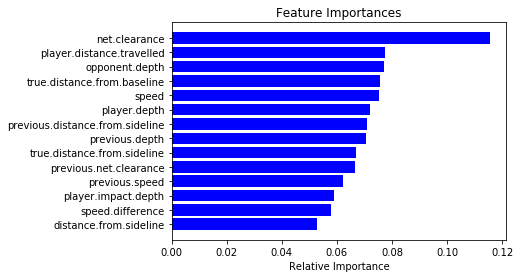

In [167]:
import numpy as np
import matplotlib.pyplot as plt
features = X_train.columns
importances = ada_model.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()


In [168]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 14 columns):
speed                              6000 non-null float64
net.clearance                      6000 non-null float64
distance.from.sideline             6000 non-null float64
player.distance.travelled          6000 non-null float64
player.impact.depth                6000 non-null float64
player.depth                       6000 non-null float64
previous.speed                     6000 non-null float64
previous.net.clearance             6000 non-null float64
previous.distance.from.sideline    6000 non-null float64
previous.depth                     6000 non-null float64
opponent.depth                     6000 non-null float64
speed.difference                   6000 non-null float64
true.distance.from.sideline        6000 non-null float64
true.distance.from.baseline        6000 non-null float64
dtypes: float64(14)
memory usage: 656.3 KB


In [173]:
impf=sorted(zip(map(lambda x: round(x, 4), ada_model.feature_importances_), X_train.columns), 
             reverse=True)
impf = pd.DataFrame(impf, index=None)
impf

,0,1
0,0.1157,net.clearance
1,0.0776,player.distance.travelled
2,0.0769,opponent.depth
3,0.0757,true.distance.from.baseline
4,0.0751,speed
5,0.0720,player.depth
6,0.0710,previous.distance.from.sideline
7,0.0704,previous.depth
8,0.0670,true.distance.from.sideline
9,0.0666,previous.net.clearance


In [185]:
impf1 = impf[1]
impf1=impf1[0:13]

In [186]:
impf1

0                       net.clearance
1           player.distance.travelled
2                      opponent.depth
3         true.distance.from.baseline
4                               speed
5                        player.depth
6     previous.distance.from.sideline
7                      previous.depth
8         true.distance.from.sideline
9              previous.net.clearance
10                     previous.speed
11                player.impact.depth
12                   speed.difference
Name: 1, dtype: object

In [207]:
Adaboost_model1 = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=6,max_features=8, max_leaf_nodes=10,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.1, presort=False, random_state=121212,
            splitter='best'),
    n_estimators=1000,
    learning_rate=0.5)


Adaboost_model1.fit(X_train[impf1], y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=6,
            max_features=8, max_leaf_nodes=10, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.1,
            presort=False, random_state=121212, splitter='best'),
          learning_rate=0.5, n_estimators=1000, random_state=None)

In [208]:
from sklearn.metrics import confusion_matrix
y_pred=Adaboost_model1.predict(X_train[impf1])
y_pred1=Adaboost_model1.predict(X_test[impf1])

print("Train Confusion matrix",confusion_matrix(y_train,y_pred))
print("Test Confusion matrix",confusion_matrix(y_test,y_pred1))

print("Train Accuracy Score",accuracy_score(y_train,y_pred))
print("Test Accuracy Score",accuracy_score(y_test,y_pred1))

Train Confusion matrix [[1114  237    7]
 [ 262 2324   36]
 [   0   16 2004]]
Test Confusion matrix [[341 101  18]
 [125 727  27]
 [ 15  33 614]]
Train Accuracy Score 0.907
Test Accuracy Score 0.8405797101449275


# Multinomial regression

In [226]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
mul_lr = LogisticRegression(multi_class='multinomial', solver='newton-cg', warm_start=True, random_state=12345, n_jobs=100).fit(X_train, y_train)
predicted_mlr = mul_lr.predict(X_train)
preds_val_mlr=mul_lr.predict(X_test)
print ('Accuracy:', accuracy_score(y_train, predicted_mlr))
print ('Accuracy:', accuracy_score(y_test, preds_val_mlr))

Accuracy: 0.738
Accuracy: 0.7146426786606697


## SVM

In [228]:
from sklearn.svm import SVC # "Support Vector Classifier" 
clf_svm = SVC(kernel='linear', gamma=5) 

# fitting x samples and y classes 
clf_svm.fit(X_train, y_train)
predicted_svm = clf_svm.predict(X_train)
preds_val_svm=clf_svm.predict(X_test)
print ('Accuracy:', accuracy_score(y_train, predicted_svm))
print ('Accuracy:', accuracy_score(y_test, preds_val_svm))

Accuracy: 0.7448333333333333
Accuracy: 0.7326336831584208


# Build KNN Classifier

In [252]:
from sklearn.neighbors import KNeighborsClassifier
knn_model= KNeighborsClassifier(algorithm = 'kd_tree',n_neighbors=7, weights='uniform', n_jobs=100 , p=2)
knn_model.fit(X_train,y_train)

#predictions
y_pred_train_knn = knn_model.predict(X_train)
y_pred_test_knn = knn_model.predict(X_test)

#Accuracy check
print(accuracy_score(y_train,y_pred_train_knn))
print(accuracy_score(y_test,y_pred_test_knn))


0.821
0.7361319340329835


# GridSearch Cross validation

In [248]:
#from sklearn.model_selection import GridSearchCV
from sklearn.grid_search import GridSearchCV
parameters = {'n_neighbors':list(range(3,15))}
clf = GridSearchCV(KNeighborsClassifier(), parameters, n_jobs=4,verbose=2)
clf.fit(X=X_train, y=y_train)
knn_model = clf.best_estimator_
print (clf.best_score_, clf.best_params_) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Fitting 3 folds for each of 12 candidates, totalling 36 fits
0.7563333333333333 {'n_neighbors': 12}


[Parallel(n_jobs=4)]: Done  36 out of  36 | elapsed:   12.8s finished


In [251]:
y_pred_train_knn_cv=knn_model.predict(X_train)
y_pred_test_knn_cv=knn_model.predict(X_test)

print(accuracy_score(y_train,y_pred_train_knn_cv))
print(accuracy_score(y_test,y_pred_test_knn_cv))

0.8075
0.7526236881559221


## Stacking

In [368]:
base_predictions_train = pd.DataFrame( {'Gridcvknn': y_pred_train_knn_cv,
     'AdaBoost_cv': y_pred_cv,
      'XGBoost': predicted_xgb,
     'Multinom': predicted_mlr,
      'svm': predicted_svm,
                                        
    })
base_predictions_train.head()

,Gridcvknn,AdaBoost_cv,XGBoost,Multinom,svm
0,UE,FE,FE,UE,UE
1,UE,UE,UE,UE,UE
2,UE,UE,UE,UE,UE
3,UE,FE,FE,FE,FE
4,W,W,W,UE,UE


In [340]:
temp= pd.DataFrame(y_pred_train_knn_cv)
target.shape

(6000,)

In [369]:
base_predictions_test = pd.DataFrame( {'Gridcvknn': y_pred_test_knn_cv,
     'AdaBoost_cv': y_pred_test_cv,
     'XGBoost': preds_val_xgb,
     'Multinom': preds_val_mlr,
     'svm': preds_val_svm,
                                        
    })
base_predictions_test.head()

,Gridcvknn,AdaBoost_cv,XGBoost,Multinom,svm
0,UE,UE,UE,UE,UE
1,UE,UE,UE,UE,UE
2,W,W,W,UE,W
3,W,W,W,UE,UE
4,UE,UE,FE,FE,FE


In [370]:
base_predictions_train["Gridcvknn"] = base_predictions_train["Gridcvknn"].replace({"FE":1,"UE":2, "W":3}) 
base_predictions_train["AdaBoost_cv"] = base_predictions_train["AdaBoost_cv"].replace({"FE":1,"UE":2, "W":3}) 
base_predictions_train["XGBoost"] = base_predictions_train["XGBoost"].replace({"FE":1,"UE":2, "W":3}) 
base_predictions_train["Multinom"] = base_predictions_train["Multinom"].replace({"FE":1,"UE":2, "W":3}) 
base_predictions_train["svm"] = base_predictions_train["svm"].replace({"FE":1,"UE":2, "W":3}) 
target = y_train.map({"FE":1,"UE":2, "W":3})#using gradient boosting method called Catboost which will accept catagorical variables


In [371]:
#base_predictions_test["Gridcvknn","knn","AdaBoost_cv","XGBoost","Multinom","svm"] =base_predictions_test["Gridcvknn","knn","AdaBoost_cv","XGBoost","Multinom","svm"].map({"FE":1,"UE":2, "W":3})
base_predictions_test["Gridcvknn"] = base_predictions_test["Gridcvknn"].replace({"FE":1,"UE":2, "W":3}) 
base_predictions_test["AdaBoost_cv"] = base_predictions_test["AdaBoost_cv"].replace({"FE":1,"UE":2, "W":3}) 
base_predictions_test["XGBoost"] = base_predictions_test["XGBoost"].replace({"FE":1,"UE":2, "W":3}) 
base_predictions_test["Multinom"] = base_predictions_test["Multinom"].replace({"FE":1,"UE":2, "W":3}) 
base_predictions_test["svm"] = base_predictions_test["svm"].replace({"FE":1,"UE":2, "W":3}) 
test_target= y_test.map({"FE":1,"UE":2, "W":3})

In [329]:
cat_cols= ["Gridcvknn","AdaBoost_cv","XGBoost","Multinom","svm"]
base_predictions_train[cat_cols]= base_predictions_train[cat_cols].astype('int64')
base_predictions_test[cat_cols]= base_predictions_test[cat_cols].astype('int64')


## Decision Tree

In [372]:
from sklearn.tree import DecisionTreeClassifier 
clf_entropy = DecisionTreeClassifier( 
            criterion = "entropy", random_state = 4444, 
            max_depth = 6, min_samples_leaf = 4) 
clf_gini = DecisionTreeClassifier(criterion = "gini", 
            random_state = 4444,max_depth=6, min_samples_leaf=4) 
  
# Performing training 
clf_entropy.fit(base_predictions_train, target)
clf_gini.fit(base_predictions_train, target)

predicted_DT_gini_stack = clf_gini.predict(base_predictions_train)
predicted_DT_entropy_stack = clf_entropy.predict(base_predictions_train)

preds1_gini_stack=clf_gini.predict(base_predictions_test)
preds1_entropy_stack=clf_entropy.predict(base_predictions_test)

In [373]:
print ('Accuracy train gini:', accuracy_score(target, predicted_DT_gini_stack))
print ('Accuracy test gini:', accuracy_score(test_target, preds1_gini_stack))

print ('Accuracy train entropy:', accuracy_score(target, predicted_DT_entropy_stack))
print ('Accuracy test entropy:', accuracy_score(test_target, preds1_entropy_stack))


Accuracy train gini: 0.994
Accuracy test gini: 0.8530734632683659
Accuracy train entropy: 0.994
Accuracy test entropy: 0.8530734632683659


## Logistic Regression on Stacked DF

In [389]:
lr = LogisticRegression(penalty='l2', max_iter=100, solver='newton-cg')
lr.fit(base_predictions_train, target)
predicted_lr = lr.predict(base_predictions_train)
preds_val_lr=lr.predict(base_predictions_test)
print ('Accuracy:', accuracy_score(target, predicted_lr))
print ('Accuracy:', accuracy_score(test_target, preds_val_lr))

Accuracy: 0.994
Accuracy: 0.8530734632683659
